In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version = 1)

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
mnist["DESCR"]

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

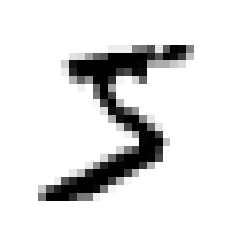

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

In [7]:
import numpy as np

y = y.astype(np.uint8)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[:60000], y[:60000], y[:60000]

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    # 利用clone复制原模型，这样可避免在原模型上进行交叉验证而改变原模型
    # 交叉验证是对模型的性能进行评估分析
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    # 在训练集中进行训练，然后在测试集中进行预测，然后比较测试集的预测结果与真实结果的差别，从而说明预测结论
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_corrent = sum(y_pred == y_test_fold)
    print(n_corrent / len(y_pred))

d:\python3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [13]:
from sklearn.model_selection import cross_val_score
# 利用标准库的交叉验证，只是在训练集中进行交叉验证，而自己实现的可以使用测试集进行交叉验证
c_v_score = cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")
print(c_v_score)

[0.95035 0.96035 0.9604 ]


In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
c_v_s_n5 = cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")
print(c_v_s_n5)

[0.91125 0.90855 0.90915]


In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(y_train_pred)

[ True False False ...  True False False]


In [17]:
from sklearn.metrics import confusion_matrix

con_matrix = confusion_matrix(y_train_5, y_train_pred)
print(con_matrix)

[[53892   687]
 [ 1891  3530]]


In [18]:
y_train_perfect_predictions = y_train_5
print(confusion_matrix(y_train_5, y_train_perfect_predictions))

[[54579     0]
 [    0  5421]]


In [19]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [20]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.7325171197343846


In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_scores)
print(y_some_digit_pred)
print(sgd_clf.predict([some_digit]))

[2164.22030239]
[ True]
[ True]


In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
print(y_scores)

[  1200.93051237 -26883.79202424 -33072.03475406 ...  13272.12718981
  -7258.47203373 -16877.50840447]


In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

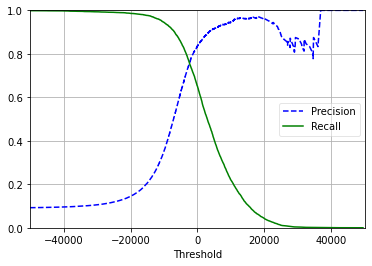

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    # plot用于画图，横坐标为第一个参数，第二个参数为纵坐标，第三个参数为图线形式，第四个参数为label
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    # xlim、ylim用于设置横坐标和纵坐标的范围
    plt.xlim(-50000, 50000)
    plt.ylim(0, 1)
    # 设置横坐标名称
    plt.xlabel("Threshold")
    # grid()用于显示网格
    plt.grid(True)
    # legend()用于显示图例
    plt.legend(loc="right", framealpha=0.5)

    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# plt.plot([threshold_90_precision, threshold_90_precison], [0., 0.9], "r:")

plt.show()

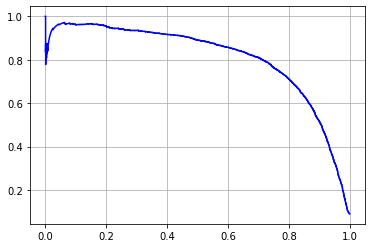

In [25]:
plt.plot(recalls, precisions, "b-")
plt.grid()
plt.show()

In [26]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

3370.0194991439557


In [27]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

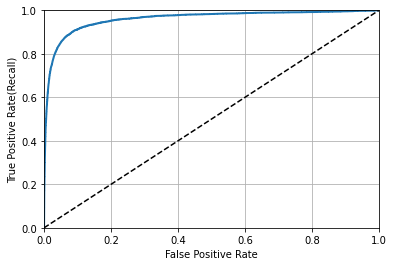

In [30]:
from sklearn.metrics import roc_curve

# 其中fpr：false positive rate   tpr: true positive rate
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate(Recall)")
    plt.grid()
    
plot_roc_curve(fpr, tpr)
plt.show()

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)# 随机森林需要提供一个随机数才能工作
y_probes_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")
print(y_probes_forest[:,1])

[0.02 0.   0.   ... 0.   0.02 0.01]


In [33]:
y_socres_forest = y_probes_forest[:, 5]# 利用置信度作为score
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_socres_forest)

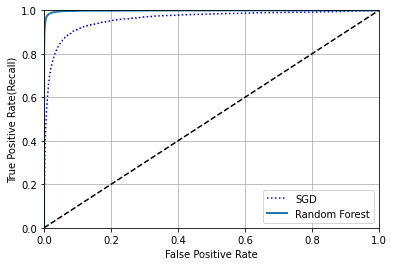

In [34]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [35]:
sgd_clf = SGDClassifier(random_state = 43)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [36]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-33088.79384069, -27918.7618197 , -12448.51881789,
          -185.8380577 , -27615.83846365,   6859.76366877,
        -24000.69970261, -11544.65996835,  -5204.36251823,
        -10775.95441337]])

In [37]:
np.argmax(some_digit_scores)

5

In [38]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [39]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [40]:
len(ovo_clf.estimators_)

45

In [41]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [42]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [43]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.8702 , 0.88485, 0.88725])

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.89935, 0.89195, 0.89845])

In [54]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5555,    0,   21,    6,    8,   52,   35,    6,  239,    1],
       [   0, 6400,   36,   24,    4,   46,    4,    7,  211,   10],
       [  27,   29, 5222,   94,   72,   25,   64,   36,  383,    6],
       [  21,   16,  117, 5227,    2,  209,   25,   40,  403,   71],
       [  10,   14,   46,    9, 5190,   11,   35,   25,  339,  163],
       [  26,   15,   28,  163,   54, 4447,   74,   15,  541,   58],
       [  30,   15,   40,    3,   43,   97, 5551,    5,  133,    1],
       [  19,   10,   50,   30,   50,   15,    3, 5697,  190,  201],
       [  17,   65,   45,   93,    3,  131,   25,   10, 5423,   39],
       [  25,   18,   30,   67,  117,   35,    1,  178,  395, 5083]],
      dtype=int64)

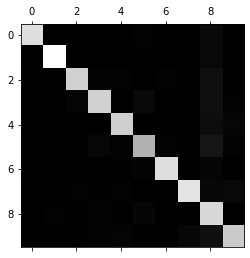

In [55]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [56]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)#axis=1:表示对每行进行求和 keepdims=True:表示保持原二维性
norm_conf_mx = conf_mx / row_sums

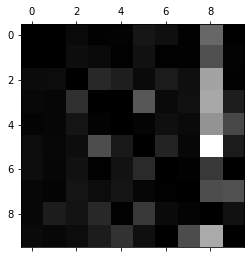

In [57]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
#行表示实际的类，列表示预测的类
#图中白色代表数值大

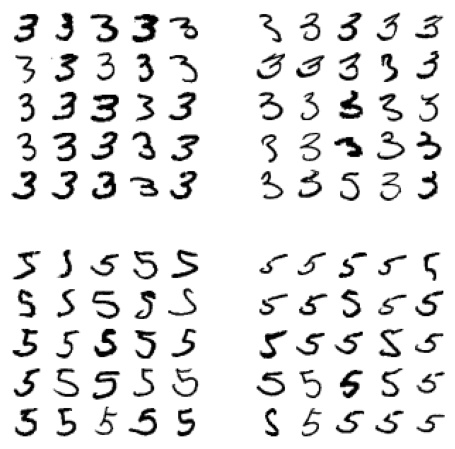

In [59]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [47]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [60]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [61]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [62]:
noise = np.random.randint(0, 100,(len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_train), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

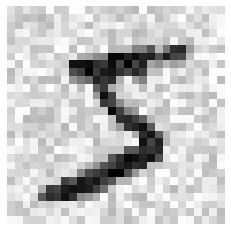

In [65]:
some_digit = X_test_mod[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

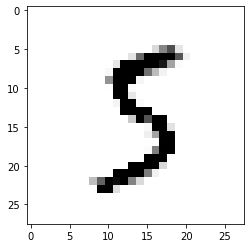

In [71]:
knn_clf.fit(X_train_mod, y_train_mod)
some_index = 0
clean_digit = knn_clf.predict([X_test_mod[some_index]])

some_digit = clean_digit
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("on")
plt.show()

In [72]:
knn_clf.predict([X_test_mod[some_index]])

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 